In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

import mccd
from astropy.io import fits

%pylab inline

print(tf.__version__)




runstats and/or skimage could not be imported because not installed
Populating the interactive namespace from numpy and matplotlib
2.4.4


In [2]:

dataset_path = '/n05data/tliaudat/new_deepmccd/training_realistic_sims/output_mccd/eigenPSF_datasets/local_eigenpsfs.fits'

dataset = fits.open(dataset_path)
dataset[1].data['VIGNETS_NOISELESS'].shape



(280000, 51, 51)

In [6]:

some_eigenPSF = dataset[1].data['VIGNETS_NOISELESS'][1000:1100,:,:]


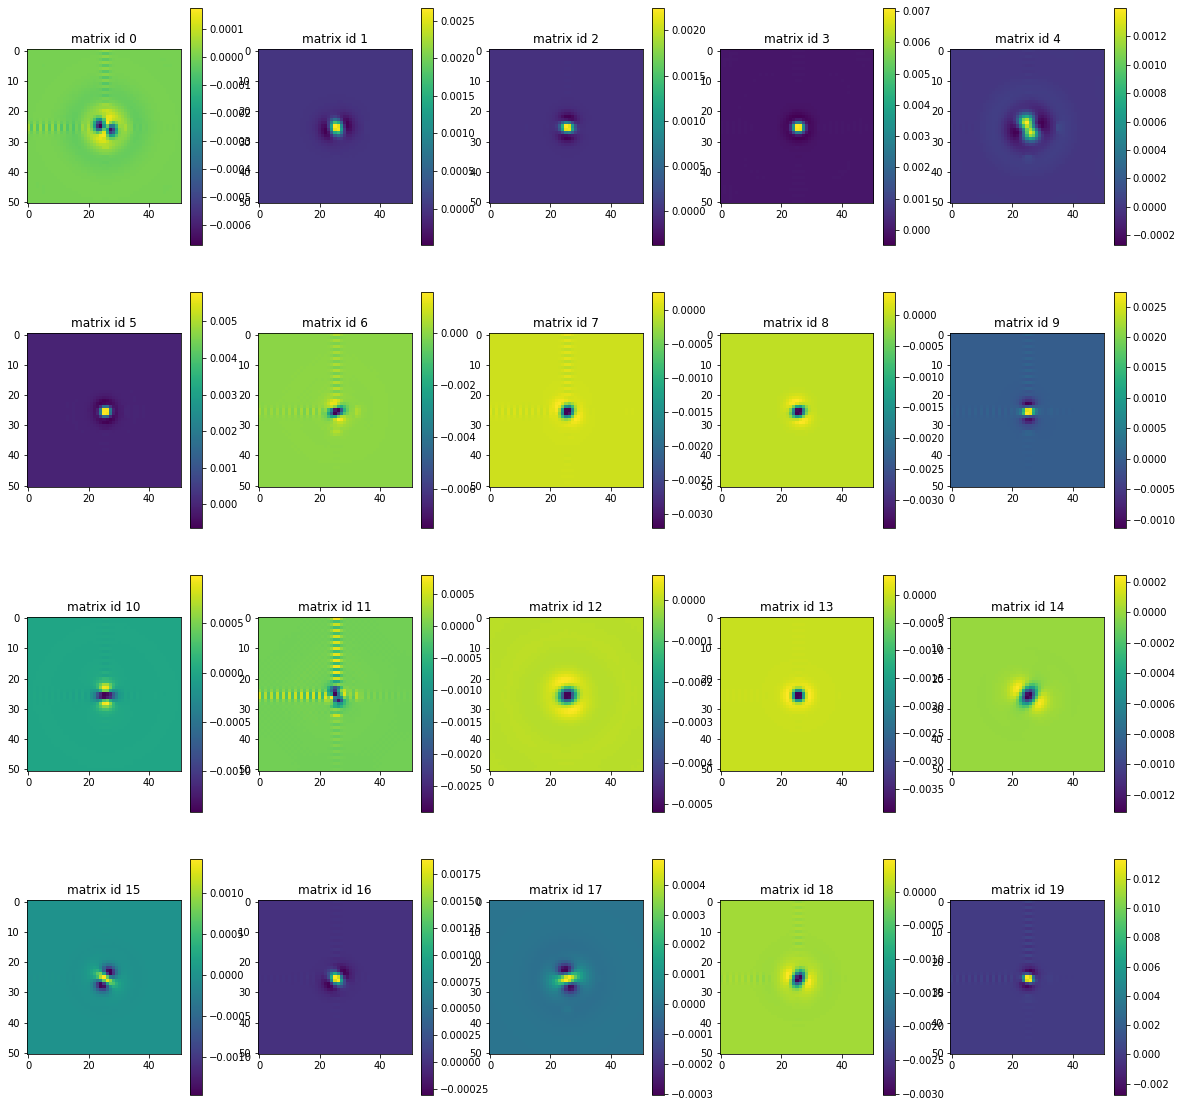

In [9]:
mccd.utils.plot_imgs(some_eigenPSF[20:40,:,:], cmap = 'viridis', figsize=(20,20))


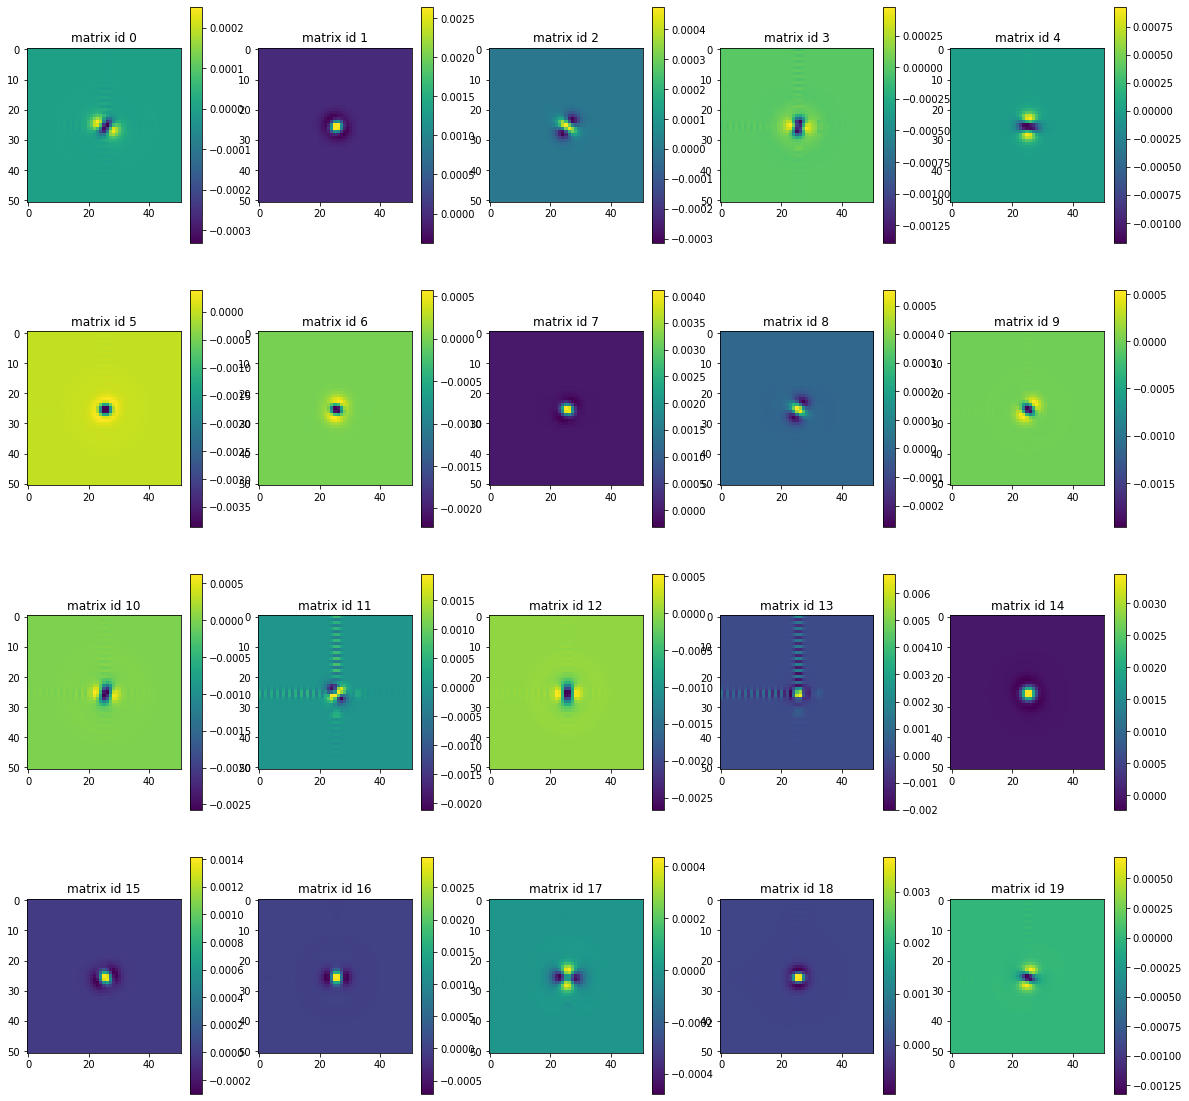

In [10]:

mccd.utils.plot_imgs(some_eigenPSF[0:20,:,:], cmap = 'viridis', figsize=(20,20))



In [11]:

def butterworth_2d_filter(im_shape, order, cut_dist):
    """ Butterworth 2D spectral filter
    
    This function generates the 2D Fourier mask of a Butterworth 
    filter of order `order` with a cut off frequency corresponding to `cut_dist`.
    """
    
    x_dim = im_shape[0]
    y_dim = im_shape[1]

    if im_shape[0] % 2 != 0:
        x_arr = np.linspace(-x_dim//2 + 1, x_dim//2 + 1, x_dim, endpoint=False)
    else:
        x_arr = np.linspace(-x_dim//2 + 0.5, x_dim//2 + 0.5, x_dim, endpoint=False)

    if im_shape[1] % 2 != 0:   
        y_arr = np.linspace(-y_dim//2 + 1, y_dim//2 + 1, y_dim, endpoint=False)
    else:
        y_arr = np.linspace(-y_dim//2 + 0.5, y_dim//2 + 0.5, y_dim, endpoint=False)

    # Generate spatial grid
    xx, yy = np.meshgrid(x_arr, y_arr)
    
    butt_filter = np.zeros(im_shape)

    for it_x in range(im_shape[0]):
        for it_y in range(im_shape[1]):
            den = (xx[it_x,it_y]**2 + yy[it_x,it_y]**2)/(cut_dist**2)
            butt_filter[it_x,it_y] = 1 / (1 + den**(order))
            
    return butt_filter
    
    
def fft_filter_image(img, fft_filter):
    """ Filter image using 2D FFT.
    """
    img_fft = np.fft.fftshift(np.fft.fft2(img))
    img_fft = img_fft * fft_filter
    return (np.fft.ifft2(np.fft.ifftshift(img_fft))).real
